<html>
<body>
<img src="http://upload.ouliu.net/i/201806251128591n574.png"  align="right" />
</body>
</html>

# Get Original Report

In [1]:
# add some features so we can choose from incomestatements,balancesheet,statement of cashflow
reportType = c('is','bs','cf')
link_head = 'http://financials.morningstar.com/ajax/ReportProcess4CSV.html?&t='
link_mid = '&region=usa&culture=en-US&version=SAL&cur=&reportType='
link_tail = '&period=12&dataType=A&order=asc&columnYear=5&curYearPart=1st5year&rounding=3&view=raw&r=769236&denominatorView=raw&number=3'

getfinrpt <- function(cik,rpt){
    if(rpt=='income'){
        links <- paste(link_head,cik,link_mid,reportType[1],link_tail,sep = "")
    } else if (rpt=='balance'){
        links <- paste(link_head,cik,link_mid,reportType[2],link_tail,sep = "")
    } else if (rpt=='cash'){
        links <- paste(link_head,cik,link_mid,reportType[3],link_tail,sep = "")
    }
    data <- read.csv2(links, sep=",",  header=FALSE,blank.lines.skip = FALSE,fill = TRUE,na.strings = "NA",stringsAsFactors = FALSE)
    colnames <- c('category')
    for (i in 2:(ncol(data)))
    {
    colnames[i] <- data[2,i]
    }
    df <- data.frame(data[3:nrow(data),1:ncol(data)],row.names = c(1:(nrow(data)-2)))
    colnames(df) <- colnames
    return(df)
}

In [2]:
#testing
income <- getfinrpt(cik = 'xnas:NFLX',rpt = 'income')
balance <- getfinrpt(cik = 'xnas:NFLX',rpt = 'balance')
cash <- getfinrpt(cik = 'xnas:NFLX',rpt = 'cash')

# DuPont Analysis 

## What is DuPont Analysis
[Accounting Analytics @ Coursera](https://www.coursera.org/learn/accounting-analytics/home)

[Morning Star](https://www.morningstar.com/stocks/xnas/nflx/quote.html)

I will use ratios below to analyze & hopefully make some reasonable forcast.

```r
fin_ratios <- read.csv2('/Users/randall/Downloads/ChromeDownload/ratios.csv', 
                        sep=",",  header=FALSE,blank.lines.skip = FALSE,fill = TRUE,na.strings = "NA",stringsAsFactors = FALSE)

colnames(fin_ratios) <- c('rations','equation')
```

![](http://upload.ouliu.net/i/20180619091012w5zzg.png)

In [3]:
#before we started, let's do some consolidation
library(plyr)
csld  <- rbind(balance, income[,1:6],cash[,1:6])
head(csld)

category,2013-12,2014-12,2015-12,2016-12,2017-12
Assets,,,,,
Current assets,,,,,
Cash,,,,,
Cash and cash equivalents,605,1114,1809,1468,2823
Short-term investments,595,495,501,266,
Total cash,1200,1608,2311,1734,2823


## Return on Equity
- Return on Equity = Net Income / Avg. Stockholders' Equity

In [4]:
NetIncome <- as.numeric(c(csld[50,3:6]))
StockholdersEquity <- as.numeric(csld[35,2:6])
AvgStockholdersEquity <- c()

for (i in 1:4){
    AvgStockholdersEquity[i] <- 0.5*(StockholdersEquity[i]+StockholdersEquity[i+1])
}

ROE <- NetIncome/AvgStockholdersEquity

### Financial Leverage

- Return on Assets = De-levered Net Income / Avg. Total Assets
>Noted:I will not de-levered NI income for now.

In [5]:
TotalAssets <- as.numeric(csld[16,2:6])
AvgTotalAssets<- c()

for (i in 1:4){
    AvgTotalAssets[i] <- 0.5*(TotalAssets[i]+TotalAssets[i+1])
}

ROA <- NetIncome/AvgTotalAssets

- Financial Leverage = Avg. Total Assets / Avg. Stockholders’ Equity

In [6]:
FinancialLeverage <- AvgTotalAssets/AvgStockholdersEquity

- Correction Factor = Net Income / De-levered Net Income
- De-levered Net Income = Net Income + (Interest Exp. * (1 - Statutory Tax Rate))

[Effective Tax Rates Can Differ Significantly from the Statutory Rate](https://www.gao.gov/products/GAO-13-520)

### Return on Assets
- Return on Sales =  De-levered Net Income / Sales 
- Asset turnover = Sales / Avg. Total Assets 

In [7]:
Sales <- as.numeric(csld[37,3:6])
ROS <- NetIncome / Sales 
AssetTurnover <- Sales / AvgTotalAssets

#### Return on Sales
##### Profitability

- Gross Margin = (Sales - Cost of Goods Sold) / Sales 
- SGA as of Sales = SGA Expense / Sales 
- Operating Margin = Operating Income / Sales 
- Interest Expense as  of Sales = Interest Expense / Sales 
- Effective Tax Rate = Income Taxes / Pre-tax Income 

[How to Calculate the Effective Tax Rate of a Corporation](https://www.fool.com/knowledge-center/how-to-calculate-the-effective-tax-rate-of-a-corpo.aspx)

[SEC FILINGS](https://www.sec.gov/Archives/edgar/data/1065280/000106528018000069/q4nflx201710k.htm#sE1D5BA7DC75D59B9843BA1F37B4C71EA)


In [8]:
GrossMargin  <-  as.numeric(csld[39,3:6]) / Sales

In [9]:
SGAasofSales <- as.numeric(csld[42,3:6]) / Sales

In [10]:
OperatingMargin <- as.numeric(csld[44,3:6]) / Sales

In [11]:
InterestExpenseasofSales <- as.numeric(csld[45,3:6]) / Sales

In [12]:
EffectiveTaxRate <- as.numeric(csld[48,3:6]) / as.numeric(csld[47,3:6]) 

##### Asset Turnover Ratios		
> NETFLIX receivables from members generally settle quickly and deferred revenue is a source of cash flow.

- Accounts Receivables Turnover = Sales / Avg. Accounts Receivable
- Inventory Turnover = Cost of Goods Sold / Avg. Inventory
- Accounts Payable Turnover = Purchases / Avg. Accounts Payable
- Fixed Asset Turnover = Sales / Avg. Net Property, Plant and Equipment

- Accounts Receivables Turnover = Sales / Avg. Accounts Receivable
- Accounts Payable Turnover = Purchases / Avg. Accounts Payable

##### Days Turnover Ratios		
- Days Receivables =  365 * (Avg. Accounts Receivable / Sales)
- Days Inventory = 365 * (Avg. Inventory / Cost of Goods Sold)
- Days Payable = 365 * (Avg. Accounts Payable / Purchases)
- Net Trade Cycle = Days Receivable + Days Inventory - Days Payable
- Net Trade Cycle = Days Receivable + Days Inventory

#### Liquidity Analysis		
- Current Ratio = Current Assets / Current Liabilities
- Quick Ratio = (Cash + Accts Rec) / Current Liabilities
- CFO-to-Current Liabilities = Cash from Operations / Avg. Current Laibilities
		
- Interest Coverage = Operating Income before Depreciation / Interest Expense
- Cash Interest Coverage = (Cash from Operations + Cash Interest + Cash Taxes) / Cash Interest Paid
		
- Debt to Equity = Total Liabilities / Total Stockholders’ Equity
- Long-Term-Debt to Equity = Total Long-Term Debt / Total Stockholders’ Equity
- Long-Term Debt to Tangible Assets = Total Long-Term Debt / (Total Assets - Intangible Assets)

In [13]:
CurrentRatio  <- as.numeric(csld[8,3:6]) / as.numeric(csld[24,3:6])

In [14]:
QuickRatio <- as.numeric(csld[4,3:6]) / as.numeric(csld[24,3:6])

In [15]:
CurrentLaibilities <- as.numeric(csld[24,2:6])
AvgCurrentLaibilities <- c()

for (i in 1:4){
    AvgCurrentLaibilities[i] <- 0.5*(CurrentLaibilities[i]+CurrentLaibilities[i+1])
}

CFOtoCurrentLiabilities <- as.numeric(csld[70,3:6]) / AvgCurrentLaibilities

In [16]:
DebttoEquity <- as.numeric(csld[29,3:6]) / as.numeric(csld[35,3:6])

In [17]:
LTDebttoEquity <- as.numeric(csld[26,3:6]) / as.numeric(csld[35,3:6])

## Other Information		
- Sales Growth = Change in Sales / Prior Year Sales
- Federal Statutory Rate + State and Foreign Statutory Rates (excludes permanent differences)
- De-levered Net Income = Net Income + (Interest Exp. * (1 - Statutory Tax Rate))
- Purchases = Ending Inventory + COGS – Beginning Inventory
- Weighted Avg Depreciation Rate = Depreciation  Amortization / (Avg. Gross PPE + Avg. Intangible Assets)
- Weighted Avg Interest Rate = Interest Expense / Avg. Long-Term Debt

In [18]:
SalesGrowth <- c()

for (i in 1:4){
    SalesGrowth[i] <- (as.numeric(csld[37,i+2]) - as.numeric(csld[37,i+1]))/as.numeric(csld[37,i+1])
}

In [19]:
#Combine the ratio tables

ratios <- data.frame(Year = c('2014','2015','2016','2017'),ROE,ROA,FinancialLeverage,ROS,AssetTurnover,GrossMargin,SGAasofSales,
                     OperatingMargin,InterestExpenseasofSales,EffectiveTaxRate,
                     CurrentRatio,QuickRatio,CFOtoCurrentLiabilities,DebttoEquity,LTDebttoEquity,SalesGrowth)

ratios

Year,ROE,ROA,FinancialLeverage,ROS,AssetTurnover,GrossMargin,SGAasofSales,OperatingMargin,InterestExpenseasofSales,EffectiveTaxRate,CurrentRatio,QuickRatio,CFOtoCurrentLiabilities,DebttoEquity,LTDebttoEquity,SalesGrowth
2014,0.16729323,0.04282277,3.906642,0.04850136,0.8829190,0.3182561,0.1593097,0.07320618,0.009082652,0.2378223,1.479534,0.4183252,0.006643139,2.798170,0.4843918,0.2582857
2015,0.06027934,0.01425261,4.229356,0.01814159,0.7856315,0.3227139,0.1815634,0.04513274,0.024188791,0.1338028,1.538810,0.5124646,-0.241886000,3.589294,1.0665767,0.2316076
2016,0.07627983,0.01572089,4.852131,0.02117540,0.7424128,0.3171781,0.1776696,0.04303023,0.016985619,0.2835249,1.247002,0.3200349,-0.363188370,4.069776,1.2552239,0.3025074
2017,0.17853721,0.03429448,5.206004,0.04780638,0.7173620,0.3449072,0.1831865,0.07175233,0.020354058,-0.1525773,1.403220,0.5164654,-0.355316821,4.307929,1.8143495,0.3240856


## Vis

In [20]:
library(ggplot2)
library(ggthemes)
windowsFonts(YaHei=windowsFont("微软雅黑") )

In [21]:
plot_function <- function(data,x,y,col,size,title){
    p<- ggplot(data,mapping = aes(x=x,y=y))+
    geom_bar(stat = 'identity', fill=col, colour=col)+
    scale_y_continuous(breaks=NULL)+
    theme_wsj(title_family = "YaHei",base_family ="YaHei",base_size = size)+
    ggtitle(title)
    return(p)
}

In [22]:
p1 <- plot_function(data=ratios,x=ratios$Year,y=ratios$ROE,col="#ff5a57",title="Netflix ROE",size=10)
p2 <- plot_function(data=ratios,x=ratios$Year,y=ratios$ROA,col="#5380e4",title="ROA",size=8)
p3 <- plot_function(data=ratios,x=ratios$Year,y=ratios$FinancialLeverage,col="#938dd2",title="Leverage",size=8)
p4 <- plot_function(data=ratios,x=ratios$Year,y=ratios$ROS,col="#55acee",title="ROS",size=6)
p5 <- plot_function(data=ratios,x=ratios$Year,y=ratios$AssetTurnover,col="#82c0e9",title="Turnover",size=6)
p6 <- plot_function(data=ratios,x=ratios$Year,y=ratios$DebttoEquity,col="#ffb400",title="DtoE",size=6)
p7 <- plot_function(data=ratios,x=ratios$Year,y=ratios$LTDebttoEquity,col="#ffaa91",title="LTDtoE",size=6)

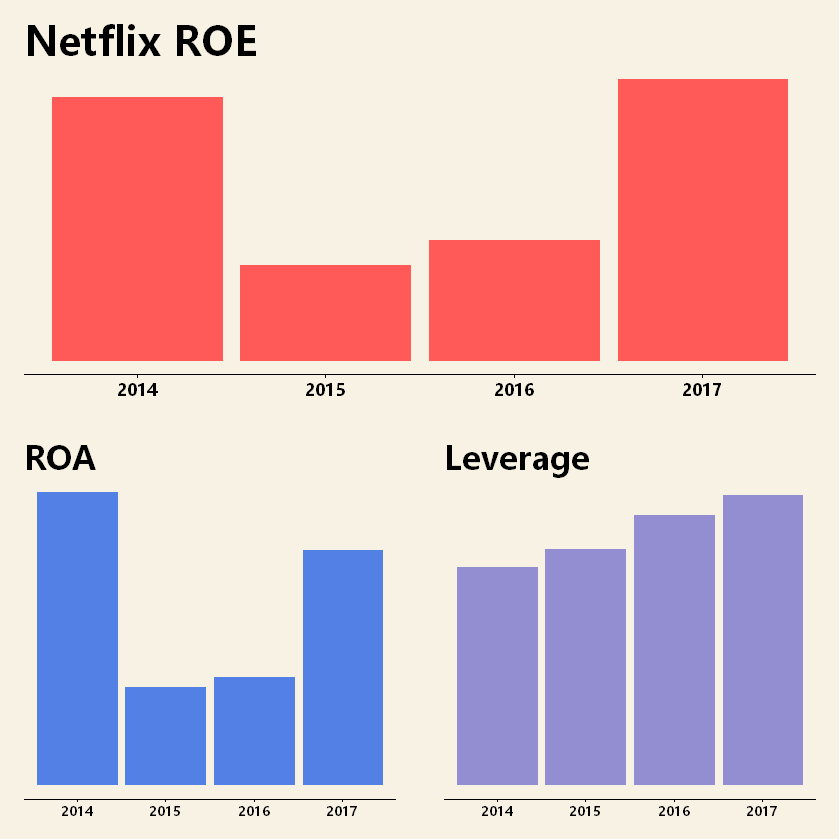

In [23]:
library(gridExtra)
grid.arrange(p1,p2,p3, layout_matrix = rbind(c(1,1),c(2,3)))

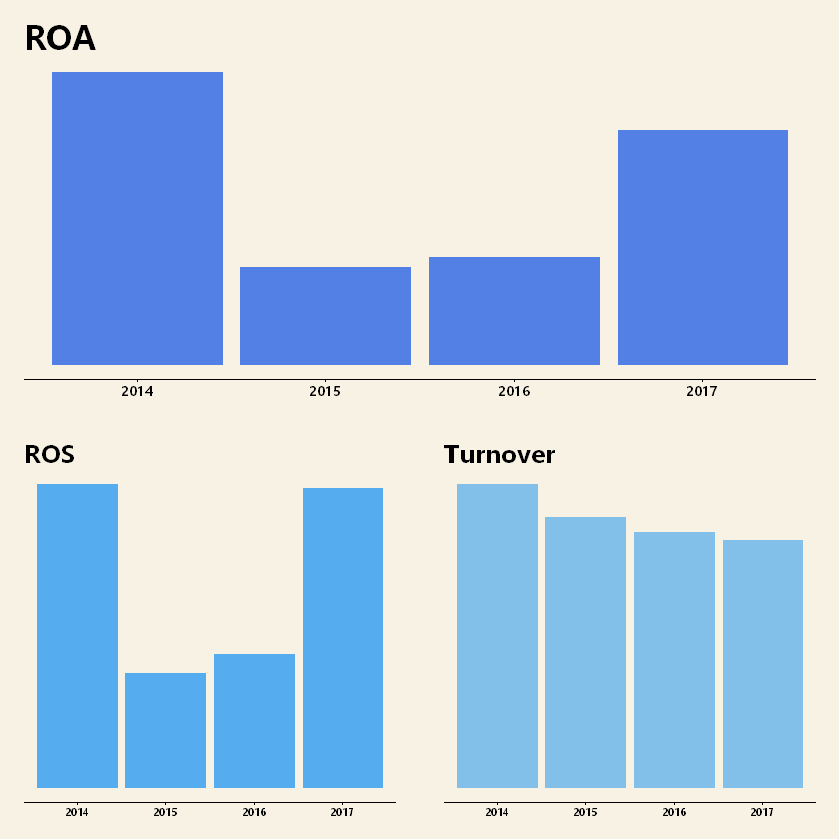

In [24]:
grid.arrange(p2,p4,p5, layout_matrix = rbind(c(1,1),c(2,3)))

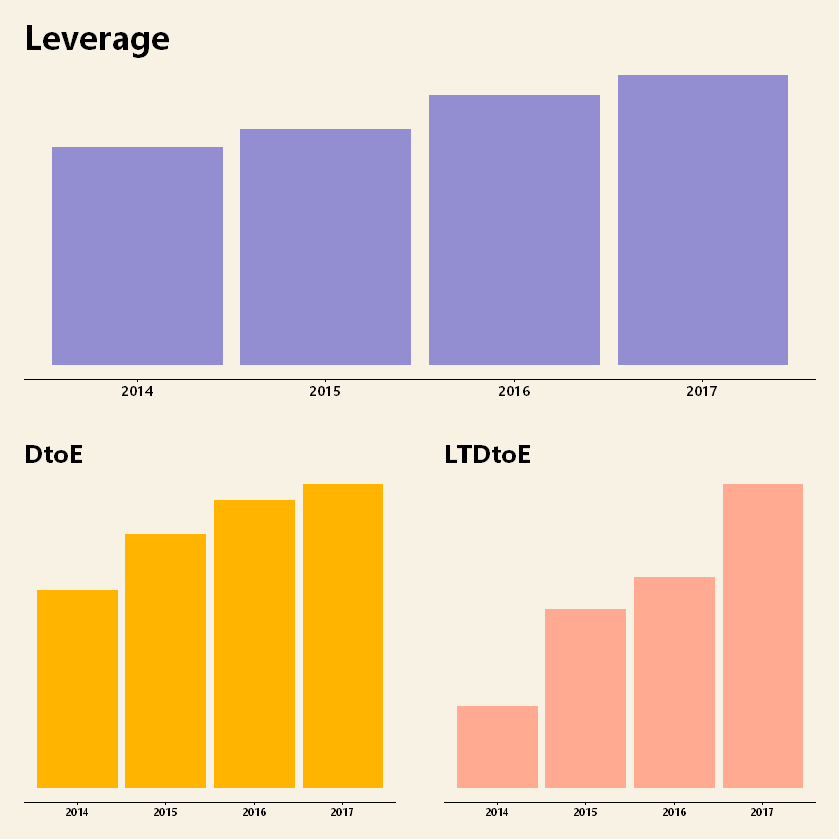

In [25]:
grid.arrange(p3,p6,p7, layout_matrix = rbind(c(1,1),c(2,3)))

## Simple Analysis
Reference: [Netflix 是怎样的一家公司](https://www.zhihu.com/question/19552101/answer/114867581)

### Operation and Financial Risk

In [26]:
#as I am not a  Premium membership with Morningstar, so let just check std of EBIT and EBITDA for 5yrs 
csld[44,]
print ('EBIT  of 2017 improved by' )
(as.numeric(csld[44,6])-as.numeric(csld[44,5]))/as.numeric(csld[44,5]) *100

,category,2013-12,2014-12,2015-12,2016-12,2017-12
44,Operating income,228,403,306,380,839


[1] "EBIT  of 2017 improved by"


[1] 120.7895

In [27]:
print ('Basic EPS  of 2017 improved by' )
(as.numeric(csld[53,6])-as.numeric(csld[53,5]))/as.numeric(csld[53,5]) *100

[1] "Basic EPS  of 2017 improved by"


[1] 193.1818

In [28]:
#Net cash provided by operating activities
csld[70,]

,category,2013-12,2014-12,2015-12,2016-12,2017-12
70,Net cash provided by operating activities,98,16,-749,-1474,-1786


#### Streaming content assets
unfortunately, we cannot see the **Streaming content assets** and someother important content from report provided by MorningStar, so I went to 
https://ir.netflix.com to check 2018 Q1 report. 
Will stop from here for the time being.

# SBUX

> ignore for now, just testing getfinrpt function

In [29]:
#testing
income_SBUX <- getfinrpt(cik = 'SBUX',rpt = 'income')
balance_SBUX <- getfinrpt(cik = 'SBUX',rpt = 'balance')
cash_SBUX <- getfinrpt(cik = 'SBUX',rpt = 'cash')

ERROR: Error in read.table(file = file, header = header, sep = sep, quote = quote, : no lines available in input


In [ ]:
library(plyr)
csld_SBUX <- rbind(balance_SBUX, income_SBUX[,1:6],cash_SBUX[,1:6])

In [ ]:
head(csld_SBUX )

```r
t1 <- cbind('2014',row.names(t(ratios[1,2:17])),t(ratios[1,2:17]))
colnames(t1) <- c('year','category','ratio')
row.names(t1) <- NULL

t2 <- cbind('2015',row.names(t(ratios[2,2:17])),t(ratios[2,2:17]))
colnames(t2) <- NULL
row.names(t2) <- NULL

t3 <- cbind('2016',row.names(t(ratios[3,2:17])),t(ratios[3,2:17]))
colnames(t3) <- NULL
row.names(t3) <- NULL

t4 <- cbind('2017',row.names(t(ratios[4,2:17])),t(ratios[4,2:17]))
colnames(t4) <- NULL
row.names(t4) <- NULL

df <- as.data.frame(rbind(t1,t2,t3,t4),stringsAsFactors = FALSE)

```

```r
ggplot(ratios, mapping = aes(x = Year, y = ROE)) + 
geom_bar(stat = 'identity', fill="#ff5a57", colour="#ff5a57") + 
scale_y_continuous(breaks=NULL) + 
theme_wsj(title_family = "YaHei",base_family ="YaHei",base_size = 10)+ 
ggtitle("Netflix ROE")+geom_text(aes(label=round(ROE,4)*100), color="white",vjust = 1)
```